# Level Truncation in String Field Theory

H. Erbin, R. Finotello, M. Kudrna

## Minimal Models

We consider minimal models in String Field Theory and their truncation levels.
We use machine learning techniques to extrapolate the value of the truncations $L$ at $\infty$ given the results using fits of polynomials in $\frac{1}{L}$.

## Deep Learning Analysis

We use the previously created notebook to predict the boundary state extrapolations using deep learning techniques.
Specifically we use *Tensorflow* and *Keras* to build different architectures.

In [1]:
%matplotlib inline

import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re
import gzip
import csv
import tqdm
import time
from datetime import datetime
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
sns.set()
ratio   = lambda x, y: (6 * y, 5 * x)

os.makedirs('./img', exist_ok=True)
os.makedirs('./models', exist_ok=True)

In [4]:
def savefig(filename, fig, show=False):
    '''
    Save a Matplotlib figure to file.
    
    Needed arguments:
        filename: the path to the saved file in the img directory (no extension),
        fig:      the Matplotlib figure object.
        
    Optional arguments:
        show: show the plot inline (bool).
    '''
    
    # save the figure to file (PDF and PNG)
    fig.tight_layout()
    fig.savefig(os.path.join('./img', filename + '.pdf'), dpi=144, format='pdf')
    fig.savefig(os.path.join('./img', filename + '.png'), dpi=144, format='png')
    
    # show if interactive
    if show:
        plt.show()
    
    # release memory
    fig.clf()
    plt.close(fig)

In [5]:
random_state = 123
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Load the Dataset

We use the pruned dataset created at the end of the [**exploratory data analysis**](./minimal-models_eda.ipynb).
We first load the JSON dataset containing the samples.
We then divide it into 80% training samples, 10% validation and 10% test.
We then write each fold into separate CSV files and load them using a generator.

In [6]:
df = pd.read_json('./data/data_ml.json.gz', orient='records')

In [7]:
# take 80% for training
df_train = df.sample(frac=0.8, random_state=random_state)
df_oos   = df.loc[~df.index.isin(df_train.index)]

n_train = df_train.shape[0]

# take 10% for validation (50% of what remains from training)
df_val   = df_oos.sample(frac=0.5, random_state=random_state)
df_test  = df_oos.loc[~df_oos.index.isin(df_val.index)].copy()

n_val  = df_val.shape[0]
n_test = df_test.shape[0]

# check that the shapes are ok
assert n_train + n_val + n_test == df.shape[0]

In [8]:
# save the input shape for later use (NB: -1 for the labels, -2 for solution and observable columns)
features_shape = (df_train.shape[1] - 1 - 2,)

We write to CSV files the three folds:

In [9]:
df_train.to_csv('./data/train.csv.gz', index=False)
df_val.to_csv('./data/val.csv.gz', index=False)
df_test.to_csv('./data/test.csv.gz', index=False)

## Normalisation of the Features

We scale the features to the interval $[0,\, 1]$ to improve scalability of the deep learning technique:

In [10]:
norm_cols    = [c for c in df_train.columns if re.match('^lev_', c)]
min_max_cols = [(c, np.min(df_train[c]), np.max(df_train[c])) for c in norm_cols]

# apply the transformation
for c, m, M in min_max_cols:
    df_train[c] = df_train[c].apply(lambda x: (x - m) / (M - m))
    df_val[c]   = df_val[c].apply(lambda x: (x - m) / (M - m))
    df_test[c]  = df_test[c].apply(lambda x: (x - m) / (M - m))

We write to CSV files the three folds:

In [11]:
df_train.to_csv('./data/train_scaled.csv.gz', index=False)
df_val.to_csv('./data/val_scaled.csv.gz', index=False)
df_test.to_csv('./data/test_scaled.csv.gz', index=False)

## Creating the Dataset

We then separate features from labels and convert to a *Tensorflow* dataset:

In [12]:
def csv_generator(file, n_rows=-1, skip_rows=1, skip_columns=0, delimiter=','):
    '''
    Read a CSV file and build a generator (last column is the label).
    
    Needed arguments:
        file: the path to the CSV file.
        
    Optional arguments:
        n_rows:       read up to n_rows unless -1 (read to the end),
        skip_rows:    number of rows to skip at the beginning,
        skip_columns: number of columns to skip on the left,
        delimiter:    type of delimiter.
    '''
    
    # handle gzipped files
    if '.gz' in file:
        op = lambda s: gzip.open(s, 'rt')
    elif '.zip' in file:
        op = lambda s: zip.open(s, 'rt')
    else:
        op = lambda s: open(s, 'r')
        
    # open and read
    with op(file) as f:
        data = csv.reader(f, delimiter=delimiter)
        if n_rows == -1:
            for i, row in enumerate(data):
                if i > skip_rows:
                    yield (np.array(row[skip_columns:-1]), row[-1])
        if n_rows > skip_rows:
            for i, row in enumerate(data):
                if i > skip_rows and i <= n_rows:
                    yield (np.array(row[skip_columns:-1]), row[-1])
        if n_rows >= 0 and n_rows <= skip_rows:
            print('n_rows should be > than skip_rows or -1.')

In [13]:
data = {'train': lambda: csv_generator('./data/train_scaled.csv.gz', skip_columns=2),
        'val':   lambda: csv_generator('./data/val_scaled.csv.gz', skip_columns=2),
        'test':  lambda: csv_generator('./data/test_scaled.csv.gz', skip_columns=2)
       }

# create datasets
train = tf.data.Dataset.from_generator(data['train'], (np.float32, np.float32), output_shapes=(features_shape, ()))
val   = tf.data.Dataset.from_generator(data['val'], (np.float32, np.float32), output_shapes=(features_shape, ()))
test  = tf.data.Dataset.from_generator(data['test'], (np.float32, np.float32), output_shapes=(features_shape, ()))

## Deep Learning - Fully Connected

We finally move to the construction of the deep learning model using *Keras*.
We first focus on fully connected layers.

In [14]:
def fc_model(layers, input_shape=(3,), leaky_relu=0.0, batch_norm=False, dropout=0.0, l1_reg=0.0, l2_reg=0.0, random_state=123, name='fc_model'):
    '''
    Build a fully connected model.
    
    Needed arguments:
        layers:      list of units per layer (list),
        input_shape: shape of the input (tuple or int).
        
    Optional arguments:
        leaky_relu:    slope of the LeakyReLU activation (float),
        batch_norm:    use batch normalisation,
        dropout:       dropout rate,
        l1_reg:        l1 regularisation factor,
        l2_reg:        l2 regularisation factor,
        random_state:  the random seed,
        name:          name of the model.
    '''
    
    # initialise Keras
    keras.backend.clear_session()
    
    # handle input shape
    if isinstance(input_shape, float):
        input_shape = (input_shape,)
        
    # build regularizer
    if l2_reg == 0.0:
        regularizer = keras.regularizers.l1(l1_reg)
    elif l1_reg == 0.0:
        regularizer = keras.regularizers.l2(l2_reg)
    else:
        regularizer = keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    
    # build the model
    I = keras.Input(shape=input_shape, name=name + '_input')
    x = I
    
    for i, units in enumerate(layers):
        x = keras.layers.Dense(units,
                               activity_regularizer=regularizer,
                               kernel_initializer=keras.initializers.glorot_uniform(random_state),
                               bias_initializer=keras.initializers.zeros(),
                               name=name + '_dense_' + str(i)
                              )(x)
        x = keras.layers.LeakyReLU(alpha=leaky_relu, name=name + '_act_' + str(i))(x)
        if batch_norm:
            x = keras.layers.BatchNormalization(name=name + '_bnorm_' + str(i))(x)
        if dropout > 0.0:
            x = keras.layers.Dropout(rate=dropout, seed=random_state, name=name + '_dout_' + str(i))(x)
            
    O = keras.layers.Dense(1,
                           kernel_initializer=keras.initializers.glorot_uniform(random_state),
                           bias_initializer=keras.initializers.zeros(),
                           name=name + '_output'
                          )(x)
    
    model = keras.Model(inputs=I, outputs=O, name=name)
    
    return model

In [15]:
model_data = {'layers': [100, 100, 25, 25],
              'input_shape': features_shape,
              'leaky_relu': 0.0,
              'batch_norm': True,
              'dropout': 0.01,
              'l1_reg': 1.0e-4,
              'l2_reg': 1.0e-3,
              'name': 'fc'
             }

# save the model into the appropriate directory
now     = datetime.now().strftime("%d%m%Y_%H%M%S")
now_dir = model_data['name'] + '_' + now
now_dir = os.path.join('./models', now_dir)
print(f'Current working directory: {now_dir}')

os.makedirs(now_dir)

# create model
model = fc_model(**model_data)

# save architecture to json
with open(os.path.join(now_dir, 'arch.json'), 'w') as f:
    json.dump(model.to_json(), f)

Current working directory: ./models/fc_25112020_104638


We can both describe and plot the model to better understand how it is made:

In [16]:
model.summary()

Model: "fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_input (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
fc_dense_0 (Dense)           (None, 100)               3200      
_________________________________________________________________
fc_act_0 (LeakyReLU)         (None, 100)               0         
_________________________________________________________________
fc_bnorm_0 (BatchNormalizati (None, 100)               400       
_________________________________________________________________
fc_dout_0 (Dropout)          (None, 100)               0         
_________________________________________________________________
fc_dense_1 (Dense)           (None, 100)               10100     
_________________________________________________________________
fc_act_1 (LeakyReLU)         (None, 100)               0        

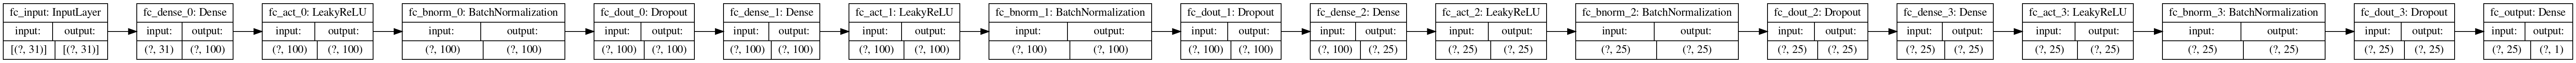

In [17]:
model_dot = keras.utils.model_to_dot(model, show_shapes=True, rankdir='LR', dpi=144)
model_dot.write_pdf('./img/fc_model_arch.pdf')
Image(model_dot.create_png())

We then move to training the model:

In [18]:
fit_data = {'epochs': 2500,
            'average': 5,
            'batch_size': 32,
            'learning_rate': 1.0e-3
           }

We first select the optimizer, the loss function and the metrics used for evaluation:

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=fit_data['learning_rate'])
loss_fn   = keras.losses.MeanSquaredError()
metrics   = {'train_mse': keras.metrics.MeanSquaredError(),
             'train_mae': keras.metrics.MeanAbsoluteError(),
             'val_mse':   keras.metrics.MeanSquaredError(),
             'val_mae':   keras.metrics.MeanAbsoluteError()
            }

We compile the training and validation functions used in the training loop:

In [20]:
def train_step(X, y_true):
    # perform one step of the GradientTape
    with tf.GradientTape() as tape:
        y_pred = model(X, training=True)
        loss   = loss_fn(y_true, y_pred)
        
    # compute the gradients
    grads = tape.gradient(loss, model.trainable_weights)
    
    # apply the gradients using the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    # update the training metrics
    metrics['train_mse'].update_state(y_true, y_pred)
    metrics['train_mae'].update_state(y_true, y_pred)
    
    return loss

def val_step(X, y_true):
    # apply the model to the data
    y_pred = model(X, training=False)
    loss   = loss_fn(y_true, y_pred)
    
    # update the validation metric
    metrics['val_mse'].update_state(y_true, y_pred)
    metrics['val_mae'].update_state(y_true, y_pred)
    
    return loss

We finally write the training loop:

In [21]:
# loop over sample size
step = 0.1
sample_sizes = np.arange(0.1, 1.0 + step, step)
train_sizes  = [int(n_train * s) for s in sample_sizes]

# history
training_data = {'train_loss': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'val_loss': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'train_mse': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'train_mae': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'val_mse': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'val_mae': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'epoch_times': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'lr': np.zeros((len(train_sizes), fit_data['epochs'], fit_data['average'])),
                 'random_states': np.random.randint(len(train_sizes) * fit_data['epochs'] * fit_data['average'],
                                                    size=(len(train_sizes), fit_data['average'])
                                                   )
                }

for t, size in enumerate(train_sizes):
    
    # print status
    print(f'Training size: {size:d} samples ({int(100 * sample_sizes[t]):d}% of the training set).')
    
    # select subsample
    train_batches = train.take(size).batch(fit_data['batch_size']).prefetch(1)
    val_batches   = val.batch(fit_data['batch_size']).prefetch(1)

    # loop over random seeds
    for seed in range(fit_data['average']):

        # print status
        print(f'\n  Beginning to train model {seed:d}...\n')

        # set new random seed
        random_state = training_data['random_states'][t,seed]
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

        # create the model
        optimizer.lr = fit_data['learning_rate']
        model        = fc_model(random_state=random_state, **model_data)

        # epochs loop
        best_loss           = np.inf
        best_loss_epoch     = 0
        best_loss_no_improv = 0
        lr_schedule         = 0
        for epoch in range(fit_data['epochs']):

            # start the epoch clock
            epoch_start = time.time()

            # training loop
            step_train_loss = []
            for x_batch_train, y_batch_train in train_batches:

                # compute the loss value and add to the list
                train_loss = train_step(x_batch_train, y_batch_train)
                step_train_loss.append(float(train_loss))

            # add average loss per epoch
            training_data['train_loss'][t,epoch,seed] = np.mean(step_train_loss)

            # compute the values of the metrics, add them to the history and reset
            train_mse = metrics['train_mse'].result()
            train_mae = metrics['train_mae'].result()

            training_data['train_mse'][t,epoch,seed] = float(train_mse)
            training_data['train_mae'][t,epoch,seed] = float(train_mae)

            metrics['train_mse'].reset_states()
            metrics['train_mae'].reset_states()

            # validation loop
            step_val_loss = []
            for x_batch_val, y_batch_val in val_batches:

                # compute the validation metrics
                val_loss = val_step(x_batch_val, y_batch_val)
                step_val_loss.append(float(val_loss))

            # add average loss per epoch
            training_data['val_loss'][t,epoch,seed] = np.mean(step_val_loss)

            # update best loss and save the weights
            if training_data['val_loss'][t,epoch,seed] < best_loss:
                best_loss           = training_data['val_loss'][t,epoch,seed]
                best_loss_epoch     = epoch
                best_loss_no_improv = 0
                print(f'    * Validation loss improved during epoch {best_loss_epoch+1:d}. Saving weights...\n')
                best_weights = os.path.join(now_dir, 'weights_' + str(t) + '_' + str(seed) + '_' + str(best_loss_epoch) + '.h5')
                model.save_weights(best_weights)
            else:
                lr_schedule += 1
                best_loss_no_improv += 1

            # reduce learning rate if necessary
            training_data['lr'][t,epoch,seed] = float(optimizer.lr)
            if lr_schedule > 0.1 * fit_data['epochs'] and best_loss_no_improv > 0.1 * fit_data['epochs'] and float(optimizer.lr) > 1.0e-5:
                optimizer.lr = float(optimizer.lr) * 0.1
                lr_schedule = 0
                print(f'    ** Reducing learning rate to {float(optimizer.lr)} at epoch {epoch:d}...\n')

            # compute the values of the metrics, add them to the history and reset
            val_mse = metrics['val_mse'].result()
            val_mae = metrics['val_mae'].result()

            training_data['val_mse'][t,epoch,seed] = float(val_mse)
            training_data['val_mae'][t,epoch,seed] = float(val_mae)

            metrics['val_mse'].reset_states()
            metrics['val_mae'].reset_states()

            # stop the epoch clock
            epoch_end = time.time() - epoch_start
            training_data['epoch_times'][t,epoch,seed] = epoch_end

            # periodically print the results of the run
            interval = int(0.05 * fit_data['epochs']) if int(0.05 * fit_data['epochs']) != 0 else 1
            if (epoch+1) % interval == 0 or epoch == fit_data['epochs']:

                # print update
                print(f'    Update at epoch {epoch+1:d}:\n'
                      f'      - loss (training, validation): ({training_data["train_loss"][t,epoch,seed]:.4f}, {training_data["val_loss"][t,epoch,seed]:.4f})\n'
                      f'      - MSE (training, validation): ({training_data["train_mse"][t,epoch,seed]:.4f}, {training_data["val_mse"][t,epoch,seed]:.4f})\n'
                      f'      - MAE (training, validation): ({training_data["train_mae"][t,epoch,seed]:.4f}, {training_data["val_mae"][t,epoch,seed]:.4f})\n'
                      f'      - average training time per epoch: {np.mean(training_data["epoch_times"][t,:,seed]):.4f} seconds\n'
                     )

        # restore best weights
        print(f'    Total training time for run {seed+1:d}: {np.sum(training_data["epoch_times"][t,:,seed]):.4f} seconds.\n')
        print(f'    Restoring best weights saved at epoch {best_loss_epoch+1:d}: {best_weights}...\n')
        model.load_weights(best_weights)
        model.save_weights(os.path.join(now_dir, 'best_weights_' + str(seed) + '_' + str(t) + '.h5'))

        # write summary to file
        with open(os.path.join(now_dir, 'summary.txt'), 'a') as f:
            f.write(f'\nTraining size {size}, model {seed:d}:')
            f.write(f'  - best validation loss:  {best_loss:.4f}')
            f.write(f'  - best validation epoch: {best_loss_epoch:.4f}')
            f.write(f'  - best weights:          {best_weights}')

# final training time
full_time = time.strftime('%H hours, %M minutes and %S seconds', time.gmtime(np.sum(training_data["epoch_times"])))
print(f'Full training time: {full_time}.\n')

Training size: 64 samples (10% of the training set).

  Beginning to train model 0...

    * Validation loss improved during epoch 1. Saving weights...

    * Validation loss improved during epoch 2. Saving weights...

    * Validation loss improved during epoch 3. Saving weights...

    * Validation loss improved during epoch 13. Saving weights...

    * Validation loss improved during epoch 14. Saving weights...

    * Validation loss improved during epoch 15. Saving weights...

    * Validation loss improved during epoch 16. Saving weights...

    * Validation loss improved during epoch 17. Saving weights...

    * Validation loss improved during epoch 18. Saving weights...

    * Validation loss improved during epoch 19. Saving weights...

    * Validation loss improved during epoch 20. Saving weights...

    * Validation loss improved during epoch 21. Saving weights...

    * Validation loss improved during epoch 22. Saving weights...

    * Validation loss improved during epoch 5

In [22]:
# save the training data
training_data_json = {}
for key, value in training_data.items():
    training_data_json[key] = value.tolist()
    
with open(os.path.join(now_dir, 'training_data.json'), 'w') as f:
    json.dump(training_data_json, f)

We the plot loss and metrics of the model for evaluation (we only consider the largest training size):

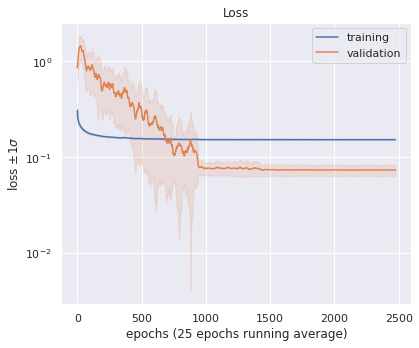

In [23]:
# plot the loss
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
running_avg = {'train_loss_mean': np.convolve(np.mean(training_data['train_loss'][-1,:,:], axis=1),
                                              np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                             ),
               'train_loss_std': np.convolve(np.std(training_data['train_loss'][-1,:,:], axis=1),
                                             np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                            ),
               'val_loss_mean': np.convolve(np.mean(training_data['val_loss'][-1,:,:], axis=1),
                                            np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                           ),
               'val_loss_std': np.convolve(np.std(training_data['val_loss'][-1,:,:], axis=1),
                                           np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                          )
              }

sns.lineplot(x=np.arange(running_avg['train_loss_mean'].shape[0]),
             y=running_avg['train_loss_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['train_loss_mean'].shape[0]),
                y1=running_avg['train_loss_mean'] + running_avg['train_loss_std'],
                y2=running_avg['train_loss_mean'] - running_avg['train_loss_std'],
                color='C0',
                alpha=0.15
               )
sns.lineplot(x=np.arange(running_avg['val_loss_mean'].shape[0]),
             y=running_avg['val_loss_mean'],
             color='C1',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['val_loss_mean'].shape[0]),
                y1=running_avg['val_loss_mean'] + running_avg['val_loss_std'],
                y2=running_avg['val_loss_mean'] - running_avg['val_loss_std'],
                color='C1',
                alpha=0.15
               )

ax.set(title='Loss', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel='loss $\pm 1\sigma$', yscale='log')
ax.legend(['training', 'validation'])
savefig('fc_loss', fig, show=True)

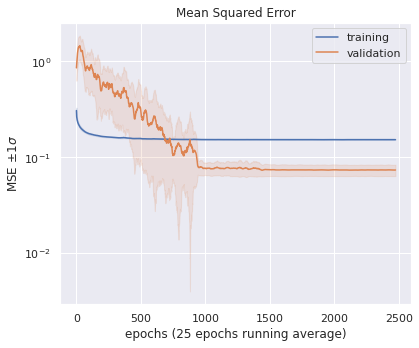

In [24]:
# plot the MSE
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
running_avg = {'train_mse_mean': np.convolve(np.mean(training_data['train_mse'][-1,:,:], axis=1),
                                             np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                            ),
               'train_mse_std': np.convolve(np.std(training_data['train_mse'][-1,:,:], axis=1),
                                            np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                           ),
               'val_mse_mean': np.convolve(np.mean(training_data['val_mse'][-1,:,:], axis=1),
                                           np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                          ),
               'val_mse_std': np.convolve(np.std(training_data['val_mse'][-1,:,:], axis=1),
                                          np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                         )
              }

sns.lineplot(x=np.arange(running_avg['train_mse_mean'].shape[0]),
             y=running_avg['train_mse_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['train_mse_mean'].shape[0]),
                y1=running_avg['train_mse_mean'] + running_avg['train_mse_std'],
                y2=running_avg['train_mse_mean'] - running_avg['train_mse_std'],
                color='C0',
                alpha=0.15
               )
sns.lineplot(x=np.arange(running_avg['val_mse_mean'].shape[0]),
             y=running_avg['val_mse_mean'],
             color='C1',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['val_mse_mean'].shape[0]),
                y1=running_avg['val_mse_mean'] + running_avg['val_mse_std'],
                y2=running_avg['val_mse_mean'] - running_avg['val_mse_std'],
                color='C1',
                alpha=0.15
               )

ax.set(title='Mean Squared Error', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel=f'MSE $\pm 1\sigma$', yscale='log')
ax.legend(['training', 'validation'])
savefig('fc_mse', fig, show=True)

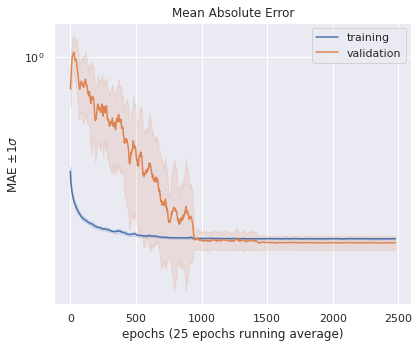

In [25]:
# plot the MAE
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
running_avg = {'train_mae_mean': np.convolve(np.mean(training_data['train_mae'][-1,:,:], axis=1),
                                             np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                            ),
               'train_mae_std': np.convolve(np.std(training_data['train_mae'][-1,:,:], axis=1),
                                            np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                           ),
               'val_mae_mean': np.convolve(np.mean(training_data['val_mae'][-1,:,:], axis=1),
                                           np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                          ),
               'val_mae_std': np.convolve(np.std(training_data['val_mae'][-1,:,:], axis=1),
                                          np.ones((int(0.01 * fit_data['epochs']),)) / int(0.01 * fit_data['epochs']), mode='valid'
                                         )
              }

sns.lineplot(x=np.arange(running_avg['train_mae_mean'].shape[0]),
             y=running_avg['train_mae_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['train_mae_mean'].shape[0]),
                y1=running_avg['train_mae_mean'] + running_avg['train_mae_std'],
                y2=running_avg['train_mae_mean'] - running_avg['train_mae_std'],
                color='C0',
                alpha=0.15
               )
sns.lineplot(x=np.arange(running_avg['val_mae_mean'].shape[0]),
             y=running_avg['val_mae_mean'],
             color='C1',
             ax=ax
            )
ax.fill_between(x=np.arange(running_avg['val_mae_mean'].shape[0]),
                y1=running_avg['val_mae_mean'] + running_avg['val_mae_std'],
                y2=running_avg['val_mae_mean'] - running_avg['val_mae_std'],
                color='C1',
                alpha=0.15
               )

ax.set(title='Mean Absolute Error', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel=f'MAE $\pm 1\sigma$', yscale='log')
ax.legend(['training', 'validation'])
savefig('fc_mae', fig, show=True)

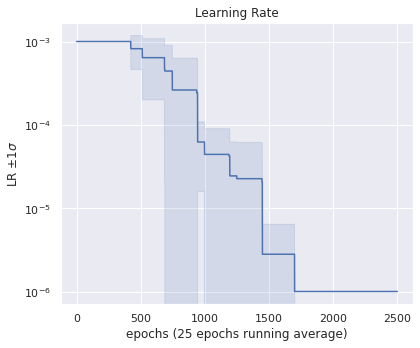

In [26]:
# plot the MAE
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))
lr_data = {'lr_mean': np.mean(training_data['lr'][-1,:,:], axis=1),
           'lr_std': np.std(training_data['lr'][-1,:,:], axis=1)
          }
sns.lineplot(x=np.arange(lr_data['lr_mean'].shape[0]),
             y=lr_data['lr_mean'],
             color='C0',
             ax=ax
            )
ax.fill_between(x=np.arange(lr_data['lr_mean'].shape[0]),
                y1=lr_data['lr_mean'] + lr_data['lr_std'],
                y2=lr_data['lr_mean'] - lr_data['lr_std'],
                color='C0',
                alpha=0.15
               )

ax.set(title='Learning Rate', xlabel=f'epochs ({int(0.01 * fit_data["epochs"]):d} epochs running average)', ylabel=f'LR $\pm 1\sigma$', yscale='log')
savefig('fc_lr', fig, show=True)

Finally we compute the predictions on the test set and evaluate the model:

MSE (training, validation, test): (1.603 ± 1.246, 12.139 ± 1.246, 12.248 ± 1.246)
MAE (training, validation, test): (0.248 ± 0.034, 0.526 ± 0.034, 0.607 ± 0.034)


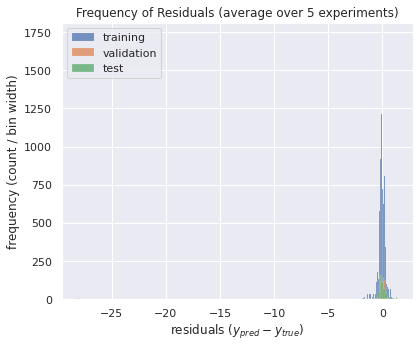

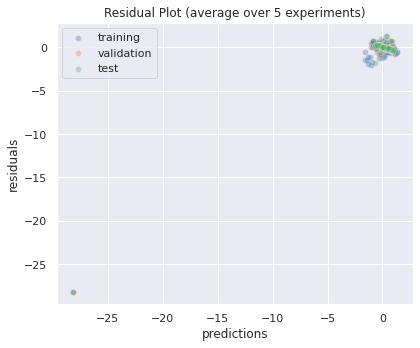

In [27]:
X_train = np.zeros((n_train, features_shape[0]))
y_train = np.zeros((n_train,))
X_val   = np.zeros((n_val, features_shape[0]))
y_val   = np.zeros((n_val,))
X_test  = np.zeros((n_test, features_shape[0]))
y_test  = np.zeros((n_test,))

for i, (X, y) in enumerate(train.as_numpy_iterator()):
    X_train[i,:] = X
    y_train[i]   = y

for i, (X, y) in enumerate(val.as_numpy_iterator()):
    X_val[i,:] = X
    y_val[i]   = y

for i, (X, y) in enumerate(test.as_numpy_iterator()):
    X_test[i,:] = X
    y_test[i]   = y
    
# load the models (take only the last train sizes)
models = [fc_model(**model_data)] * fit_data['average']
models = [models[n].load_weights(os.path.join(now_dir, 'best_weights_' + str(n) + '_' + str(len(train_sizes)-1) + '.h5')) for n in range(fit_data['average'])]

# compute the predictions
y_train_pred = np.zeros((n_train,fit_data['average']))
y_val_pred   = np.zeros((n_val,fit_data['average']))
y_test_pred  = np.zeros((n_test,fit_data['average']))

for i in range(fit_data['average']):
    # create the model and load weights
    with open(os.path.join(now_dir, 'arch.json'), 'r') as m:
        model = keras.models.model_from_json(json.load(m))
    model.load_weights(os.path.join(now_dir, 'best_weights_' + str(i) + '_' + str(len(train_sizes)-1) + '.h5'))
    
    # compute predictions
    y_train_pred[:,i] = model(X_train, training=False).numpy().reshape(-1,)
    y_val_pred[:,i]   = model(X_val, training=False).numpy().reshape(-1,)
    y_test_pred[:,i]  = model(X_test, training=False).numpy().reshape(-1,)

# evaluate the model
full_metrics = {'train_mse':     np.mean(np.mean(np.square(y_train_pred - y_train.reshape(-1,1)), axis=0)),
                'train_mse_std': np.std(np.mean(np.square(y_train_pred - y_train.reshape(-1,1)), axis=0)),
                'train_mae':     np.mean(np.mean(np.abs(y_train_pred - y_train.reshape(-1,1)), axis=0)),
                'train_mae_std': np.std(np.mean(np.abs(y_train_pred - y_train.reshape(-1,1)), axis=0)),
                'val_mse':       np.mean(np.mean(np.square(y_val_pred - y_val.reshape(-1,1)), axis=0)),
                'val_mse_std':   np.std(np.mean(np.square(y_val_pred - y_val.reshape(-1,1)), axis=0)),
                'val_mae':       np.mean(np.mean(np.abs(y_val_pred - y_val.reshape(-1,1)), axis=0)),
                'val_mae_std':   np.std(np.mean(np.abs(y_val_pred - y_val.reshape(-1,1)), axis=0)),
                'test_mse':      np.mean(np.mean(np.square(y_test_pred - y_test.reshape(-1,1)), axis=0)),
                'test_mse_std':  np.std(np.mean(np.square(y_test_pred - y_test.reshape(-1,1)), axis=0)),
                'test_mae':      np.mean(np.mean(np.abs(y_test_pred - y_test.reshape(-1,1)), axis=0)),
                'test_mae_std':  np.std(np.mean(np.abs(y_test_pred - y_test.reshape(-1,1)), axis=0))
               }

print(f'MSE (training, validation, test): ({full_metrics["train_mse"]:.3f} ± {full_metrics["train_mse_std"]:.3f}, {full_metrics["val_mse"]:.3f} ± {full_metrics["train_mse_std"]:.3f}, {full_metrics["test_mse"]:.3f} ± {full_metrics["train_mse_std"]:.3f})')
print(f'MAE (training, validation, test): ({full_metrics["train_mae"]:.3f} ± {full_metrics["train_mae_std"]:.3f}, {full_metrics["val_mae"]:.3f} ± {full_metrics["train_mae_std"]:.3f}, {full_metrics["test_mae"]:.3f} ± {full_metrics["train_mae_std"]:.3f})')

# evaluate the residuals
train_resid = y_train_pred - y_train.reshape(-1,1)
val_resid   = y_val_pred - y_val.reshape(-1,1)
test_resid  = y_test_pred - y_test.reshape(-1,1)

# plot the univariate distribution of the residuals
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.histplot(np.mean(train_resid, axis=1),
             stat='frequency',
             color='C0',
             ax=ax
            )
sns.histplot(np.mean(val_resid, axis=1),
             stat='frequency',
             color='C1',
             ax=ax
            )
sns.histplot(np.mean(test_resid, axis=1),
             stat='frequency',
             color='C2',
             ax=ax
            )
ax.set(title=f'Frequency of Residuals (average over {fit_data["average"]:d} experiments)',
       xlabel='residuals ($y_{pred} - y_{true}$)',
       ylabel='frequency (count / bin width)'
      )
ax.legend(['training', 'validation', 'test'])

savefig('fc_hist', fig, show=True)

# plot the residuals plot
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.scatterplot(x=np.mean(y_train_pred, axis=1),
                y=np.mean(train_resid, axis=1),
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=np.mean(y_val_pred, axis=1),
                y=np.mean(val_resid, axis=1),
                alpha=0.35,
                ax=ax
               )
sns.scatterplot(x=np.mean(y_test_pred, axis=1),
                y=np.mean(test_resid, axis=1),
                alpha=0.35,
                ax=ax
               )
ax.set(title=f'Residual Plot (average over {fit_data["average"]:d} experiments)',
       xlabel='predictions',
       ylabel='residuals'
      )
ax.legend(['training', 'validation', 'test'])

savefig('fc_resplot', fig, show=True)

Finally we plot the learning curve:

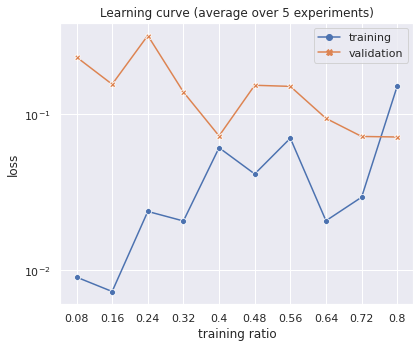

In [28]:
# compute the average loss
lc_data = {'training':   np.min(np.mean(training_data['train_loss'], axis=-1), axis=-1),
           'validation': np.min(np.mean(training_data['val_loss'], axis=-1), axis=-1)
          }

# plot the data
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.lineplot(data=lc_data,
             markers=True,
             dashes=False,
             ax=ax
            )

ax.set(title=f'Learning curve (average over {fit_data["average"]:d} experiments)',
       xlabel='training ratio',
       ylabel='loss',
       yscale='log',
       xticks=range(len(sample_sizes)),
       xticklabels=[round(s * 0.8, 2) for s in sample_sizes]
      )

savefig('fc_lc', fig, show=True)